In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain, combinations, permutations
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import random

In [2]:
# FOR SHOWING EDGES, POINTS, CUT LINES, AND INTERSECTION POINTS
def showAsImage(new_points, cut_lines, intersections):
    img = np.zeros((10,10,3), np.uint8)
    plt.clf()
    fig = plt.figure(figsize=(10, 10))
    
    # showing outer points
    x_values = []
    y_values = []
    for index in range(len(new_points)):
        x =  new_points[index]
        if(index >= len(new_points)-1):
            y = new_points[0]
        else:
            y = new_points[index+1]
        x_values = [x[0], y[0]]
        y_values = [x[1], y[1]]
        plt.plot(x_values, y_values, color="r", marker="o", linestyle="-")

    # showing intersections of cut lines
    x_values = []
    y_values = []
    for intPoint in intersections:
        plt.plot(intPoint[0], intPoint[1], color="#fff", marker="o", linestyle="-")

    # showing cut lines
    x_values = []
    y_values = []
    for line in cut_lines:
        x_values = [line[0][0], line[1][0]]
        y_values = [line[0][1], line[1][1]]
        plt.plot(x_values, y_values, color="g", marker="", linestyle="-")

    plt.imshow(img)

# FOR SHOWING LIST OF RECTANGLES
def showAllRects(rectangles):
    img = np.zeros((10,10,3), np.uint8)
    plt.clf()
    fig = plt.figure(figsize=(10, 10))

    # showing outer points
    x_values = []
    y_values = []
    break_at = 4
    i = 0
    for box in rectangles:
        i += 1
        if i > break_at:
            # break
            pass
        # draw rectangle

        r = lambda: random.randint(128,255)
        # print('#%02X%02X%02X' % (r(),r(),r()))
        color = str('#%02X%02X%02X' % (r(),r(),r()))
        x_values = [box[0][0], box[1][0], box[2][0], box[3][0], box[0][0]]
        y_values = [box[0][1], box[1][1], box[2][1], box[3][1], box[0][1]]
        plt.plot(x_values, y_values, color=color, marker="o", linestyle="-")
        # plt.imshow(img)
        # break

    plt.imshow(img)


In [15]:
# FOR MAKING THE EDGES
def makeEdges(points):
    edges = []
    for i in range(len(points)):
        edges.append([points[i], points[(i+1)%len(points)]])
    return edges

# FOR FINDING THE PROJECTION POINT ON EDGE
def proj(x, y, p):
    x1, y1 = x[0], x[1]
    x2, y2 = y[0], y[1]
    xp, yp = p[0], p[1]
    x12 = x2 - x1
    y12 = y2 - y1
    dotp = x12 * (xp - x1) + y12 * (yp - y1)
    dot12 = x12 * x12 + y12 * y12
    if dot12:
        coeff = dotp / dot12
        lx = x1 + x12 * coeff
        ly = y1 + y12 * coeff
        return (int(lx), int(ly))
    else:
        return False

# FOR CHECKING IF POINT C FALL ON LINE AB
def is_point_in_line(a, b, c, log=False):
    if (a[0] == b[0] and c[0] == a[0]):
        if (a[1] <= c[1] <= b[1]) or (a[1] >= c[1] >= b[1]):
            return True
        else:
            return False
    elif (a[1] == b[1] and c[1] == a[1]):
        if (a[0] <= c[0] <= b[0]) or (a[0] >= c[0] >= b[0]):
            return True
        else:
            return False
    return False

# FOR CHECKING IF A AND B ARE IN SAME AXIS
def is_in_same_axis(a, b):
    if (a[0] == b[0] or a[1] == b[1]):
        return True
    return False

# FOR CHECKING IF THE CUT LINE DOES NOT OVERLAPS ANY EDGE LINE
def fallOnNoEdge(cut, edges):
    for edge in edges:
        if edge[0] == cut[0]:
            if is_point_in_line(cut[0], cut[1], edge[1]):
                return True
        elif edge[1] == cut[0]:
            if is_point_in_line(cut[0], cut[1], edge[0]):
                # print("fallOnNoEdge:", cut, edge)
                return True
        elif edge[0] == cut[1]:
            if is_point_in_line(cut[0], cut[1], edge[1]):
                # print("fallOnNoEdge:", cut, edge)
                return True
        elif edge[1] == cut[1]:
            if is_point_in_line(cut[0], cut[1], edge[0]):
                # print("fallOnNoEdge:", cut, edge)
                return True
    return False

# FOR FINDING THE INTERSECTION OF CUT LINES
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return int(x), int(y)

# FOR CHECKING IF TWO BOXES ARE INTERSECTING OR NOT
def hasOverLap(box1, box2):
    poly1 = Polygon(box1)
    poly2 = Polygon(box2)
    return poly1.intersection(poly2).area > 0

# FOR FINDING RECTANGLES IN SET OF POINTS
def findRetangles(all_points, rectangles=[], max_area=0, primary_poly=None):
    # rectangles = []
    comb_count = 0
    perMutCombinations = permutations(all_points, 4)
    perMutCombinations = list(perMutCombinations)
    comb_count = len(perMutCombinations)
    comb_count_index = 0
    for comb in list(perMutCombinations):
        comb_count_index += 1
        print("\r\r", f"{comb_count_index:,}/{comb_count:,}", "percent", round(comb_count_index*100/comb_count, 2), "% max_area: ", max_area, end="")
        # print("\r\r {:n}/{:n}".format(comb_count_index, comb_count), end="")
        tmp = list(comb)
        poly = Polygon(tmp)
        # if poly is rectangle
        if poly.area == poly.minimum_rotated_rectangle.area and poly.area != 0:
            box_already_entered = False
            for b in permutations(tmp):
                b = list(b)
                if b in rectangles:
                    box_already_entered = True
                    break
            if not box_already_entered:
                # tmp is rectangle
                # if poly.area > max_area:
                #     return [tmp], True, poly.area

                allowd_to_add = False
                if len(rectangles) == 0:
                    allowd_to_add = True
                    # rectangles.append(tmp)
                else:
                    has_overlap = False 
                    for rect in rectangles:
                        if hasOverLap(tmp, rect):
                            has_overlap = True
                            break
                    if not has_overlap:
                        allowd_to_add = True
                        # rectangles.append(tmp)
                if allowd_to_add:
                    # poly = Polygon(rectangles[0])
                    if primary_poly.intersection(poly).is_closed:
                        if poly.area > max_area:
                            return [tmp], True, poly.area
                        # continue
                        rectangles.append(tmp)
    return rectangles, False, max_area  

# COMBINES RECTANGLES THAT FORMS ANOTHER RETANGLES# COMBINES RECTANGLES THAT FORMS ANOTHER RETANGLES
def mergeRectangle(rectangles):
    # print("accepting", rectangles)
    prev_rects = rectangles.copy()
    merged_rects = []
    n = 2
    possible_combs = chain.from_iterable(combinations(rectangles, i) for i in range(n, len(rectangles)+1))
    # new_rectangles = rectangles.copy()
    for possibility in possible_combs:
        # print(possibility)
        rects = []
        for box in possibility:
            p = Polygon(box)
            rects.append(p)
        u = unary_union(rects)
        if u.area == u.minimum_rotated_rectangle.area and u.area !=0:
            # get points of u
            # print(u.bounds)
            bounds = [  
                ( int(u.bounds[0]), int(u.bounds[1]) ),
                ( int(u.bounds[2]), int(u.bounds[1]) ), 
                ( int(u.bounds[2]), int(u.bounds[3]) ), 
                ( int(u.bounds[0]), int(u.bounds[3]) )
            ]
            # print(bounds)
            merged_rects.append(u)
            for box in possibility:
                if box in rectangles:
                    rectangles.remove(box)
                # else:
                #     print("not found ", box)
            rectangles.append(bounds)
        elif rects[0].intersection(rects[1]).area > 0:
            # print("dadadad")
            common_poly = rects[0].intersection(rects[1])
            p1 = None
            if rects[0].area > rects[1].area:
                if possibility[1] in rectangles:
                    rectangles.remove(possibility[1])
                p1 = rects[1].symmetric_difference(common_poly)
            else:
                if possibility[0] in rectangles:
                    rectangles.remove(possibility[0])
                p1 = rects[0].symmetric_difference(common_poly)
            if p1.area > 0:
                bounds = [  
                    ( int(p1.bounds[0]), int(p1.bounds[1]) ),
                    ( int(p1.bounds[2]), int(p1.bounds[1]) ), 
                    ( int(p1.bounds[2]), int(p1.bounds[3]) ), 
                    ( int(p1.bounds[0]), int(p1.bounds[3]) )
                ]
            rectangles.append(bounds)
                
    # print("retuning", rectangles)
    return rectangles, prev_rects

len 14 P:  [(2, 0), (6, 0), (6, 2), (8, 2), (8, 5), (7, 5), (7, 7), (5, 7), (5, 9), (3, 9), (3, 7), (0, 7), (0, 2), (2, 2)]
len 14 P:  [(2, 0), (6, 0), (6, 2), (8, 2), (8, 5), (7, 5), (7, 7), (5, 7), (5, 9), (3, 9), (3, 7), (0, 7), (0, 2), (2, 2)]
ints :  [(6, 5), (5, 2), (3, 2), (5, 5), (3, 5), (2, 5)]


<Figure size 432x288 with 0 Axes>

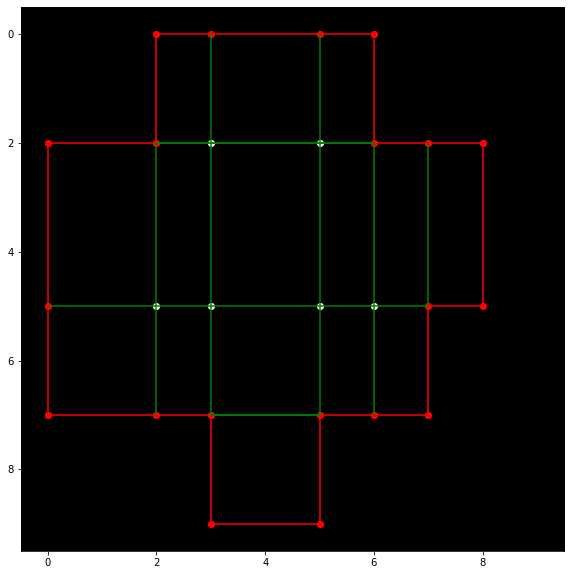

In [11]:
# FOR FINDING EDGES, CUT LINES AND INTERSECTION POINTS
# points = [(0,0), (3,0), (3,2), (7,2), (7,3), (5,3), (2,3), (2,5), (0,5)]
# points = [(0,0), (3,0), (3,2), (7,2), (7,0), (9,0), (9,5), (5,5), (5,3), (2,3), (2,5), (0,5)]
points = [(2,0), (6,0), (6,2), (8,2), (8,5), (7,5), (7,7), (5,7), (5,9), (3,9), (3,7), (0,7), (0,2), (2,2) ]

primary_poly = Polygon(points)
cut_lines = []
print("len", len(points), "P: ", points)
new_points = points.copy()
edges = makeEdges(points)

# EXPANDING PROJECTION POINTS OF EACH POINT TO RESPECTIVE EAGE
for p in points:
    for edge in edges:
        proj_point = proj(edge[0], edge[1], p)
        if is_point_in_line(edge[0], edge[1], proj_point):
            cut = [p, proj_point]
            if p != proj_point and cut not in edges and not fallOnNoEdge(cut, edges):
                if proj_point not in new_points:
                    new_points.insert(new_points.index(edge[0])+1, proj_point)
                center_point = (cut[0][0] + cut[1][0])/2, (cut[0][1] + cut[1][1])/2
                if not primary_poly.contains(Point(proj_point)) and not primary_poly.contains(Point(center_point)):
                    continue
                cut_lines.append([p, proj_point])
print("len", len(points), "P: ", points)

intersections = []
# FINDING INTERSECTION POINTS ON EACH EDGE
for i in range(len(cut_lines)):
    for j in range(len(cut_lines)):
        line1 = cut_lines[i]
        line2 = cut_lines[j]
        if line1 == line2 or line1[0]==line2[0] or line1[0]==line2[1] or line1[1]==line2[0] or line1[1]==line2[1]:
            continue
        int_point = line_intersection(line1, line2)
        if int_point is not None and int_point not in intersections and int_point not in new_points:
            intersections.append(int_point)

# print("len", len(points), "P: ", points)
print("ints : ", intersections)
showAsImage(new_points, cut_lines, intersections)

 Restart count  1  new max_area:  0  <===
 Restart count  2  new max_area:  7.0  <===
 Restart count  3  new max_area:  14.0  <===0
 358,800/358,800 percent 100.0 % max_area:  14.0[[(3, 0), (5, 0), (5, 7), (3, 7)], [(2, 0), (3, 0), (3, 7), (2, 7)], [(5, 0), (6, 0), (6, 2), (5, 2)], [(6, 2), (7, 2), (7, 5), (6, 5)], [(6, 2), (6, 7), (5, 7), (5, 2)], [(7, 2), (8, 2), (8, 5), (7, 5)], [(7, 5), (7, 7), (6, 7), (6, 5)], [(5, 7), (5, 9), (3, 9), (3, 7)], [(2, 7), (0, 7), (0, 5), (2, 5)], [(0, 5), (0, 2), (2, 2), (2, 5)]]


<Figure size 432x288 with 0 Axes>

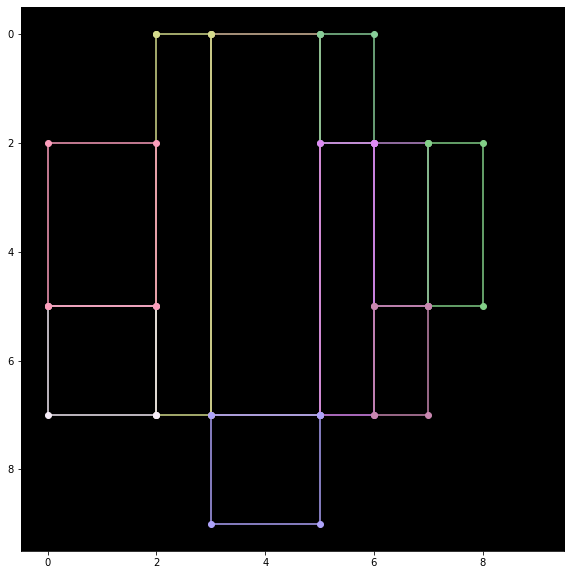

In [12]:
# max_area without intersection points
i = 0
rectangles = []
max_area = 0
foundNewMax = True
all_points = new_points + intersections

# CHECKING FOR ALL POSSIBLE RETANGLES AND FINDING MAX AREA
while foundNewMax == True:
    i += 1
    print("\r\r\r Restart count ", i, " new max_area: ", max_area, " <===")
    rectangles, foundNewMax, max_area = findRetangles(all_points, rectangles, max_area, primary_poly)

print(rectangles)
showAllRects(rectangles)

<Figure size 432x288 with 0 Axes>

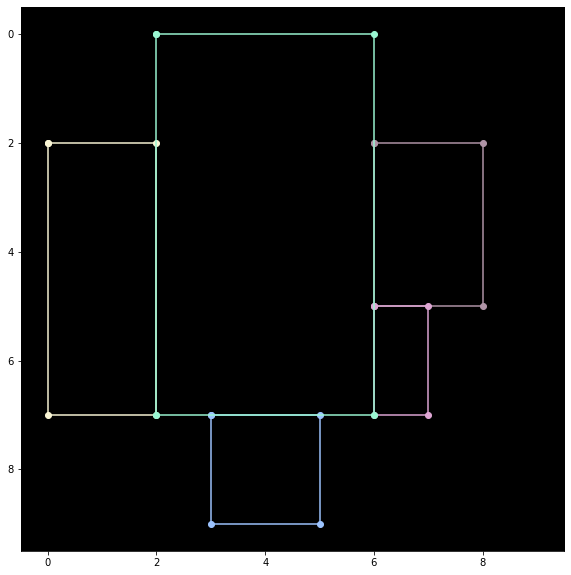

In [16]:
# COMBININF RECTANGLES
prev_rects = rectangles.copy()
new_rectangles = []
while new_rectangles != prev_rects:
    new_rectangles, prev_rects = mergeRectangle(prev_rects)
    prev_rects = new_rectangles
new_rectangles, prev_rects = mergeRectangle(prev_rects)
showAllRects(new_rectangles)
    

In [6]:
# test places

<Figure size 432x288 with 0 Axes>

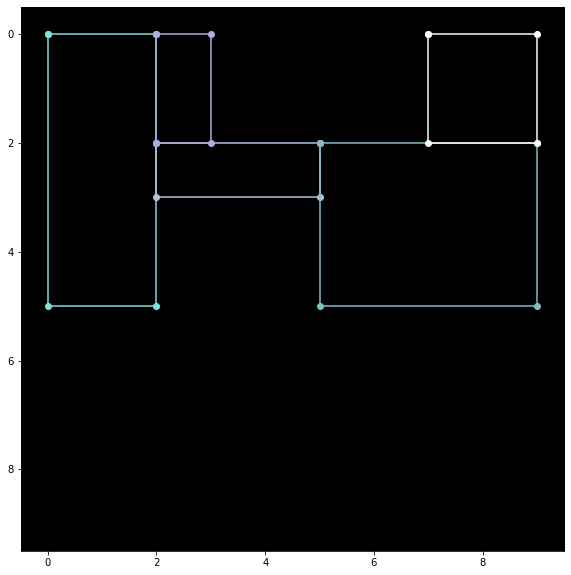

In [270]:
# prev_rects = rectangles.copy()
# new_rectangles = []
new_rectangles, prev_rects = mergeRectangle(prev_rects)
showAllRects(new_rectangles)

<Figure size 432x288 with 0 Axes>

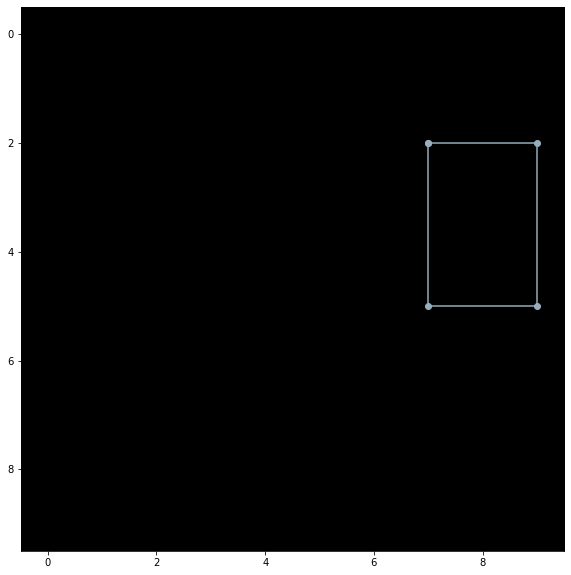

In [260]:
showAllRects([new_rectangles[3]])

In [154]:
r1 = new_rectangles[2]
r2 = new_rectangles[3]
all_rs = [r1, r2]

In [266]:
# COMBINES RECTANGLES THAT FORMS ANOTHER RETANGLES
def mergeRectangle(rectangles):
    # print("accepting", rectangles)
    prev_rects = rectangles.copy()
    merged_rects = []
    n = 2
    possible_combs = chain.from_iterable(combinations(rectangles, i) for i in range(n, len(rectangles)+1))
    # new_rectangles = rectangles.copy()
    for possibility in possible_combs:
        # print(possibility)
        rects = []
        for box in possibility:
            p = Polygon(box)
            rects.append(p)
        u = unary_union(rects)
        if u.area == u.minimum_rotated_rectangle.area and u.area !=0:
            # get points of u
            # print(u.bounds)
            bounds = [  
                ( int(u.bounds[0]), int(u.bounds[1]) ),
                ( int(u.bounds[2]), int(u.bounds[1]) ), 
                ( int(u.bounds[2]), int(u.bounds[3]) ), 
                ( int(u.bounds[0]), int(u.bounds[3]) )
            ]
            # print(bounds)
            merged_rects.append(u)
            for box in possibility:
                if box in rectangles:
                    rectangles.remove(box)
                # else:
                #     print("not found ", box)
            rectangles.append(bounds)
        elif rects[0].intersection(rects[1]).area > 0:
            # print("dadadad")
            common_poly = rects[0].intersection(rects[1])
            p1 = None
            if rects[0].area > rects[1].area:
                if possibility[1] in rectangles:
                    rectangles.remove(possibility[1])
                p1 = rects[1].symmetric_difference(common_poly)
            else:
                if possibility[0] in rectangles:
                    rectangles.remove(possibility[0])
                p1 = rects[0].symmetric_difference(common_poly)
            bounds = [  
                ( int(p1.bounds[0]), int(p1.bounds[1]) ),
                ( int(p1.bounds[2]), int(p1.bounds[1]) ), 
                ( int(p1.bounds[2]), int(p1.bounds[3]) ), 
                ( int(p1.bounds[0]), int(p1.bounds[3]) )
            ]
            rectangles.append(bounds)
                
    # print("retuning", rectangles)
    return rectangles, prev_rects

<Figure size 432x288 with 0 Axes>

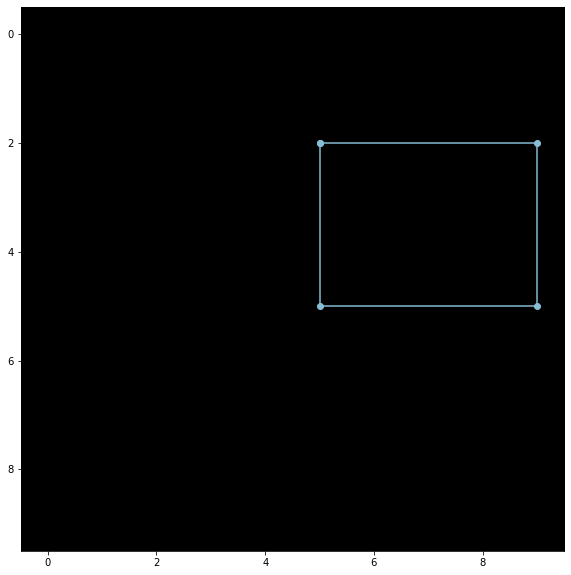

In [261]:
r1 = new_rectangles[0]
r2 = new_rectangles[3]
all_rs = [r1, r2]

# showAllRects(all_rs)
all_rs, old_rs = mergeRectangle(all_rs)
showAllRects(all_rs)

In [198]:
rr1 = Polygon(r1)
rr2 = Polygon(r2)
rr3 = Polygon(r3)

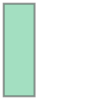

In [244]:
rr1

In [231]:
new_poly = rr1.intersection(rr2)
# rr2 = rr2.intersection(new_poly)
rr1.symmetric_difference(new_poly).area

2.0

In [233]:
new_poly.area

1.0

In [206]:
# rr1
a = rr2.__sub__(new_poly)

In [209]:
new_poly.area

1.0

<Figure size 432x288 with 0 Axes>

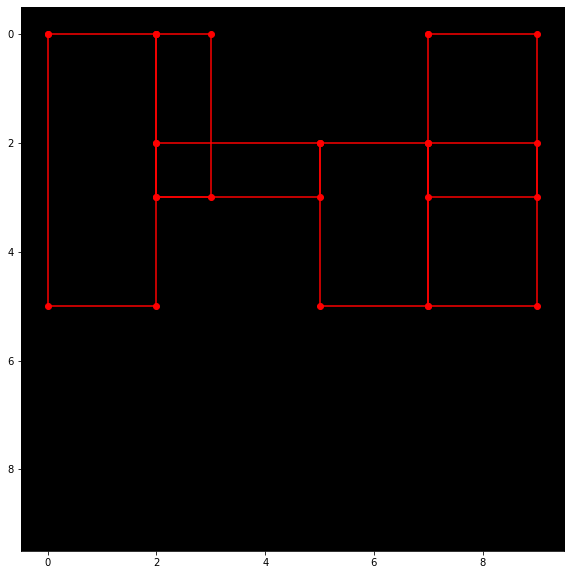

In [114]:
# COMBININF RECTANGLES
prev_rects = rectangles.copy()
new_rectangles = []
while new_rectangles != prev_rects:
    new_rectangles, prev_rects = mergeRectangle(prev_rects)
    prev_rects = new_rectangles

showAllRects(new_rectangles)
    

In [107]:
poly = Polygon(rectangles[0])
test1 = primary_poly.intersection(poly)
test1.is_closed

False

In [106]:
poly.bounds

(3.0, 0.0, 9.0, 2.0)

In [96]:
rectangles[0]

[(3, 0), (3, 2), (9, 2), (9, 0)]

In [28]:

merged_rects = []
n = 2
possible_combs = chain.from_iterable(combinations(rectangles, i) for i in range(n, len(rectangles)+1))

for possibility in possible_combs:
    rects = []
    for box in possibility:
        p = Polygon(box)
        rects.append(p)
    u = unary_union(rects)
    if u.area == u.minimum_rotated_rectangle.area and u.area !=0:
        # get points of u
        print(u.bounds)
        bounds = [(u.bounds[0], u.bounds[1]), (u.bounds[2], u.bounds[1]), (u.bounds[2], u.bounds[3]), (u.bounds[0], u.bounds[3])]
        print(bounds)
        merged_rects.append(u)
        for box in possibility:
            rectangles.remove(box)
        rectangles.append(bounds)
    # break
    # print("possibility: ", possibility)
    

(2.0, 0.0, 3.0, 3.0)
[(2.0, 0.0), (3.0, 0.0), (3.0, 3.0), (2.0, 3.0)]
(2.0, 2.0, 5.0, 3.0)
[(2.0, 2.0), (5.0, 2.0), (5.0, 3.0), (2.0, 3.0)]


ValueError: list.remove(x): x not in list

In [18]:
possibility

([(0, 0), (2, 0), (2, 3), (0, 3)], [(2, 3), (2, 5), (0, 5), (0, 3)])

In [36]:
primary_poly

NameError: name 'primary_poly' is not defined

In [74]:
from shapely.geometry import LineString

line1 = [(0,0), (9,0)]
line2 = [(3,0), (7,0)]
line3 = [(0, 2), (3, 2)]
primary_poly
l1 = LineString(line1)
l2 = LineString(line2)
l3 = LineString(line3)


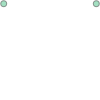

In [76]:
primary_poly.intersection(l2)

In [77]:
l3.within(primary_poly)

True

In [38]:
primary_poly = Polygon(points)

In [131]:
import random
r = lambda: random.randint(0,255)
print()

#5CD5E8


'#E8B270'